In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import matplotlib.pyplot as plt 
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
import requests
import json
from pandas.io.json import json_normalize
from geopy import distance

In [1]:
cuenta = 1
if cuenta == 1:
    # Cuenta 1 
    CLIENT_ID = '#########################################' # your Foursquare ID
    CLIENT_SECRET = '#########################################' # your Foursquare Secret
    VERSION = '20180604'
    print('Account 1')
    print('Your credentails:')
    print('CLIENT_ID: ' + CLIENT_ID)
    print('CLIENT_SECRET: ' + CLIENT_SECRET)
elif cuenta == 2:
    # Cuenta 2 
    CLIENT_ID = '#########################################' # your Foursquare ID
    CLIENT_SECRET = '#########################################' # your Foursquare Secret
    VERSION = '20180604'
    print('Account 2')
    print('Your credentails:')
    print('CLIENT_ID: ' + CLIENT_ID)
    print('CLIENT_SECRET: ' + CLIENT_SECRET)
else: print('No Account Selected')
    

Account 1
Your credentails:
CLIENT_ID: #########################################
CLIENT_SECRET: #########################################


In [3]:
# Coordenadas de Madrid 
M_lat = 40.4165000
M_long = -3.7025600
radius = 600 # Radio de análisis

In [4]:
# 4 circles aproach 
center = (M_lat, M_long)
distance_wanted = radius/2
v_dist = 0
h_dist = 0
point = (center[0] + v_dist, center[1] + h_dist )
for i in range(1000):
    if distance.distance(center, point).m >= distance_wanted:
        break 
    v_dist += 0.00001
    point = (center[0] + v_dist, center[1] + h_dist ) 

lat_var = v_dist
#print(lat_var, distance.distance(center, point).m)

v_dist = 0
h_dist = 0
point = (center[0] + v_dist, center[1] + h_dist )
for i in range(1000):
    if distance.distance(center, point).m >= distance_wanted:
        break 
    h_dist += 0.00001
    point = (center[0] + v_dist, center[1] + h_dist ) 

lon_var = h_dist
#print(lon_var, distance.distance(center, point).m)

North_point = (center[0] + lat_var, center[1])
South_point = (center[0] - lat_var, center[1])
East_point = (center[0] , center[1] + lon_var)
West_point = (center[0] , center[1] - lon_var)

print(North_point, distance.distance(center, North_point).m)
print(South_point, distance.distance(center, South_point).m)
print(East_point, distance.distance(center, East_point).m)
print(West_point, distance.distance(center, West_point).m)

four_points = [North_point, South_point, East_point, West_point]

(40.41921, -3.70256) 300.92564420173096
(40.41379, -3.70256) 300.9255027063894
(40.4165, -3.69902) 300.44961797950856
(40.4165, -3.7061) 300.44961797950856


In [5]:
madrid_map = folium.Map(location=[M_lat, M_long], zoom_start=15)
folium.Circle(
    [M_lat, M_long],
    radius= radius,
    popup='Ecco',
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.2
    ).add_to(madrid_map)
for i in range(4):
    folium.Circle(
        four_points[i],
        radius= radius/2,
        popup='Ecco',
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.2
        ).add_to(madrid_map)

madrid_map

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

df_list = []
LIMIT = 50
for i in range(4):
    lat = four_points[i][0]
    long = four_points[i][1]
    search_query = 'Restaurant'
    url_search = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, search_query, radius/2, LIMIT)
    results = requests.get(url_search).json()
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    dataframe_filtered.drop(columns='labeledLatLngs', inplace=True)
    df_list.append(dataframe_filtered)
   
for i in range(4):
    print(df_list[i].shape[0])

50
35
39
43


In [7]:
df_4points = pd.concat(df_list, sort=False)
df_4points

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood
0,Restaurant Alquds,Persian Restaurant,Chinchilla 7,40.419594,-3.703794,112,28013,ES,Madrid,Madrid,España,"[Chinchilla 7, 28013 Madrid Madrid, España]",NaN,59d15bc77247503e696c7bb3,NaN
1,Restaurant Hotel Catalonia Gran Via,Spanish Restaurant,NaN,40.419107,-3.699013,300,NaN,ES,NaN,NaN,España,[España],NaN,5375c420498e09408ded88e2,NaN
2,Restaurant Verona,Restaurant,San Marco 5,40.421511,-3.699345,373,280003,ES,Madrid,Madrid,España,"[San Marco 5, 280003 Madrid Madrid, España]",NaN,51a5101b498e210b86874fd5,NaN
3,湖南餐馆 Hunan Restaurant,Chinese Restaurant,NaN,40.421204,-3.703597,238,28004,ES,Madrid,Madrid,España,"[28004 Madrid Madrid, España]",NaN,5b64b0fada2e00002c3276ae,NaN
4,Hunan Restaurant,Chinese Restaurant,NaN,40.421159,-3.703085,221,NaN,ES,NaN,NaN,España,[España],NaN,5b4ca65116fa04002ca91e2d,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,Kechua Restaurante Peruano,Restaurant,NaN,40.417232,-3.708718,236,NaN,ES,NaN,NaN,España,[España],NaN,5644ebf4498ea0ff845ff95f,NaN
39,Taberna Restaurante El Salero,Tapas Restaurant,Calle de las Navas de Tolosa 7,40.419126,-3.706823,298,28013,ES,Madrid,Madrid,España,"[Calle de las Navas de Tolosa 7, 28013 Madrid ...",NaN,4c868734d8086dcba6439b52,NaN
40,Terra a nosa bar restaurante,None,Plaza de san miguel,40.415519,-3.708754,250,NaN,ES,Madrid,Madrid,España,"[Plaza de san miguel (Plaza de san miguel), Ma...",Plaza de san miguel,4c5dbd1994fd0f474154cc45,NaN
41,Bar Restaurante Antón,Restaurant,"Calle Mayor, 63",40.415571,-3.710096,354,28013,ES,Madrid,Madrid,España,"[Calle Mayor, 63 (Calle Cava Baja), 28013 Madr...",Calle Cava Baja,4ef901460cd689475b39ad58,NaN


In [8]:
df_4points.drop_duplicates(subset='id', inplace=True)
df_4points.reset_index(drop=True,inplace=True)
df_4points

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood
0,Restaurant Alquds,Persian Restaurant,Chinchilla 7,40.419594,-3.703794,112,28013,ES,Madrid,Madrid,España,"[Chinchilla 7, 28013 Madrid Madrid, España]",NaN,59d15bc77247503e696c7bb3,NaN
1,Restaurant Hotel Catalonia Gran Via,Spanish Restaurant,NaN,40.419107,-3.699013,300,NaN,ES,NaN,NaN,España,[España],NaN,5375c420498e09408ded88e2,NaN
2,Restaurant Verona,Restaurant,San Marco 5,40.421511,-3.699345,373,280003,ES,Madrid,Madrid,España,"[San Marco 5, 280003 Madrid Madrid, España]",NaN,51a5101b498e210b86874fd5,NaN
3,湖南餐馆 Hunan Restaurant,Chinese Restaurant,NaN,40.421204,-3.703597,238,28004,ES,Madrid,Madrid,España,"[28004 Madrid Madrid, España]",NaN,5b64b0fada2e00002c3276ae,NaN
4,Hunan Restaurant,Chinese Restaurant,NaN,40.421159,-3.703085,221,NaN,ES,NaN,NaN,España,[España],NaN,5b4ca65116fa04002ca91e2d,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Por una Cabeza Restaurante,Argentinian Restaurant,NaN,40.416320,-3.708750,225,NaN,ES,NaN,NaN,España,[España],NaN,53b80fcc498eeed934b362e3,NaN
126,Kechua Restaurante Peruano,Restaurant,NaN,40.417232,-3.708718,236,NaN,ES,NaN,NaN,España,[España],NaN,5644ebf4498ea0ff845ff95f,NaN
127,Taberna Restaurante El Salero,Tapas Restaurant,Calle de las Navas de Tolosa 7,40.419126,-3.706823,298,28013,ES,Madrid,Madrid,España,"[Calle de las Navas de Tolosa 7, 28013 Madrid ...",NaN,4c868734d8086dcba6439b52,NaN
128,Terra a nosa bar restaurante,None,Plaza de san miguel,40.415519,-3.708754,250,NaN,ES,Madrid,Madrid,España,"[Plaza de san miguel (Plaza de san miguel), Ma...",Plaza de san miguel,4c5dbd1994fd0f474154cc45,NaN


In [9]:
for lat, lng, label in zip(df_4points.lat, df_4points.lng, df_4points.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(madrid_map)
madrid_map

In [10]:
df_4points[['name','categories','lat','lng']].groupby('categories').count().sort_values(by='name',ascending=False)['name']

categories
Spanish Restaurant               32
Restaurant                       31
Tapas Restaurant                  5
Chinese Restaurant                5
Mediterranean Restaurant          5
Vegetarian / Vegan Restaurant     3
Vietnamese Restaurant             2
Seafood Restaurant                2
Asian Restaurant                  2
Korean Restaurant                 2
Italian Restaurant                2
Breakfast Spot                    2
Paella Restaurant                 2
Snack Place                       2
Café                              2
New American Restaurant           1
Pub                               1
Peruvian Restaurant               1
Sushi Restaurant                  1
Persian Restaurant                1
Szechuan Restaurant               1
Performing Arts Venue             1
Thai Restaurant                   1
Argentinian Restaurant            1
Music Venue                       1
Cuban Restaurant                  1
BBQ Joint                         1
Bar              

In [11]:
def get_extra_features(venue_row):
    venue_id = venue_row['id']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #Rating
    try:
        ##if result['meta']['errorType'] == 'quota_exceeded'
        rating =  result['response']['venue']['rating']
        
    except: 
        rating = np.NaN
    #RatingSignals    
    try:
        rating_signal =  result['response']['venue']['ratingSignals']
        
    except: 
        rating_signal = np.NaN
        
    #Price Tier
    try:
        price_tier =  result['response']['venue']['attributes']['groups'][0]['items'][0]['priceTier']
        
    except: 
        price_tier = np.NaN
        
    return [rating, rating_signal, price_tier]

In [12]:
df_4points_half1 = df_4points.iloc[0:48]
df_4points_half2 = df_4points.iloc[48:93]
new_features = []
for i, row in df_4points_half1.iterrows():
    new_features.append(get_extra_features(row))

new_features = np.array(new_features)
df_4points_half1['rating'] = new_features[:, 0]
df_4points_half1['rating_Signal'] = new_features[:, 1]
df_4points_half1['price_tier'] = new_features[:, 2]
df_4points_half1['true_rating'] = (df_4points_half1['rating'] * df_4points_half1['rating_Signal'] + 10 ) / (df_4points_half1['rating_Signal'] + 2)

# Cuenta 2 
CLIENT_ID = 'RVNC24V4CALKFFLZYKWDEQ21ACO2P1MLWYZLK1NRR1GR5FFP' # your Foursquare ID
CLIENT_SECRET = 'MU0XYVPTGW43BZ0LWZPTRBMB3YIV4MEC2CVLRC4KUY0AHZWR' # your Foursquare Secret

new_features = []
for i, row in df_4points_half2.iterrows():
    new_features.append(get_extra_features(row))

new_features = np.array(new_features)
df_4points_half2['rating'] = new_features[:, 0]
df_4points_half2['rating_Signal'] = new_features[:, 1]
df_4points_half2['price_tier'] = new_features[:, 2]
df_4points_half2['true_rating'] = (df_4points_half2['rating'] * df_4points_half2['rating_Signal'] + 10 ) / (df_4points_half2['rating_Signal'] + 2)

df_4points = pd.concat([df_4points_half1, df_4points_half2], sort=False)
df_4points


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood,rating,rating_Signal,price_tier,true_rating
0,Restaurant Alquds,Persian Restaurant,Chinchilla 7,40.419594,-3.703794,112,28013,ES,Madrid,Madrid,España,"[Chinchilla 7, 28013 Madrid Madrid, España]",NaN,59d15bc77247503e696c7bb3,NaN,NaN,NaN,NaN,NaN
1,Restaurant Hotel Catalonia Gran Via,Spanish Restaurant,NaN,40.419107,-3.699013,300,NaN,ES,NaN,NaN,España,[España],NaN,5375c420498e09408ded88e2,NaN,NaN,NaN,2.0,NaN
2,Restaurant Verona,Restaurant,San Marco 5,40.421511,-3.699345,373,280003,ES,Madrid,Madrid,España,"[San Marco 5, 280003 Madrid Madrid, España]",NaN,51a5101b498e210b86874fd5,NaN,NaN,NaN,2.0,NaN
3,湖南餐馆 Hunan Restaurant,Chinese Restaurant,NaN,40.421204,-3.703597,238,28004,ES,Madrid,Madrid,España,"[28004 Madrid Madrid, España]",NaN,5b64b0fada2e00002c3276ae,NaN,NaN,NaN,1.0,NaN
4,Hunan Restaurant,Chinese Restaurant,NaN,40.421159,-3.703085,221,NaN,ES,NaN,NaN,España,[España],NaN,5b4ca65116fa04002ca91e2d,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Restaurante Marina Ventura,Restaurant,NaN,40.415561,-3.698889,105,28014,ES,Madrid,Madrid,España,"[28014 Madrid Madrid, España]",NaN,5267be8111d2d695cc6193ba,NaN,6.7,15.0,2.0,6.500000
89,Restaurante Parisienne,Restaurant,"Jovellanos, 6",40.417029,-3.696669,207,NaN,ES,Madrid,Madrid,España,"[Jovellanos, 6, Madrid Madrid, España]",NaN,4d4d2d4e8195548121cfd493,NaN,NaN,NaN,2.0,NaN
90,Restaurante La Mojigata,Restaurant,NaN,40.414512,-3.698712,222,NaN,ES,NaN,NaN,España,[España],NaN,4f5bb4d3e4b082b23d58825e,NaN,NaN,NaN,2.0,NaN
91,Restaurante Zerain,Spanish Restaurant,"Calle QUEVEDO, 3, BARRIO DE LAS CORTES",40.414094,-3.697632,292,28014,ES,Madrid,Madrid,España,"[Calle QUEVEDO, 3, BARRIO DE LAS CORTES, 28014...",NaN,4b352189f964a520a92a25e3,NaN,7.9,68.0,2.0,7.817143


In [13]:
# Si lo pudisemos hacer de una hariamos esto directamente: 
if False:
    new_features = []
    for i, row in df.iterrows():
        new_features.append(get_extra_features(row))

    new_features = np.array(new_features)
    df['rating'] = new_features[:, 0]
    df['rating_Signal'] = new_features[:, 1]
    df['price_tier'] = new_features[:, 2]
    df['true_rating'] = (df['rating'] * df['rating_Signal'] + 10 ) / (df['rating_Signal'] + 2)

In [14]:
data_df1 = df_4points.dropna(subset=['true_rating','price_tier'])
print(data_df1.shape[0])
data_df2 = df_4points.dropna(subset=['true_rating'])
print(data_df2.shape[0])


27
30


In [15]:
data_df = df_4points.dropna(subset=['true_rating'])
data_df.reset_index(drop=True, inplace=True)
data_df

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood,rating,rating_Signal,price_tier,true_rating
0,Caramba. Restaurant & Bar,Restaurant,19 Calle de Alcalá,40.417741,-3.699755,288,28014,ES,Madrid,Madrid,España,"[19 Calle de Alcalá, 28014 Madrid Madrid, España]",NaN,5969465e2e26800cfee878c8,NaN,5.8,26.0,2.0,5.742857
1,Restaurante La Terraza de Salud,Paella Restaurant,"Calle Salud, 13",40.419170,-3.703269,60,28013,ES,Madrid,Madrid,España,"[Calle Salud, 13, 28013 Madrid Madrid, España]",NaN,4dbd614a0437955ec04a9751,NaN,5.8,22.0,3.0,5.733333
2,Restaurante de Sichuan,Szechuan Restaurant,NaN,40.419566,-3.701119,128,NaN,ES,NaN,NaN,España,[España],NaN,56360349498eae12045aa55d,NaN,7.3,19.0,NaN,7.080952
3,Restaurante Cerveceria El Jamonal,Spanish Restaurant,Mesonero Romanos,40.419543,-3.704427,162,NaN,ES,Madrid,Madrid,España,"[Mesonero Romanos, Madrid Madrid, España]",NaN,4c716caed274b60c0f67dc0d,NaN,5.7,12.0,2.0,5.600000
4,Restaurante Puerto Rico,Spanish Restaurant,"Chinchilla, 2",40.419336,-3.703984,121,28013,ES,Madrid,Madrid,España,"[Chinchilla, 2, 28013 Madrid Madrid, España]",NaN,4c249e59c11dc9b62dae2524,NaN,7.6,69.0,2.0,7.526761
5,Restaurante Casa9,Mediterranean Restaurant,"Calle REINA, 9",40.420450,-3.700359,232,28004,ES,Madrid,Madrid,España,"[Calle REINA, 9, 28004 Madrid Madrid, España]",NaN,4f0c48aac2ee59c89837b083,NaN,7.9,57.0,2.0,7.801695
6,Restaurante Casa Labra,Restaurant,Tetuan 12,40.416996,-3.704125,279,NaN,ES,Madrid,Madrid,España,"[Tetuan 12, Madrid Madrid, España]",NaN,55bbc016498ed18b24cfe9c5,NaN,7.3,8.0,2.0,6.840000
7,restaurante variopintos,Restaurant,Carrera De San Jeronimo 5,40.416782,-3.701473,285,NaN,ES,Madrid,Madrid,España,"[Carrera De San Jeronimo 5, Madrid Madrid, Esp...",NaN,52fe887c498e07737d99bfaa,NaN,7.1,10.0,2.0,6.750000
8,Restaurante Zara,Cuban Restaurant,C. Barbieri 8,40.420954,-3.700368,268,28004,ES,Madrid,Madrid,España,"[C. Barbieri 8, 28004 Madrid Madrid, España]",NaN,4b62d8a0f964a52039552ae3,NaN,7.3,77.0,2.0,7.241772
9,Restaurante Pozo Real,Restaurant,"calle del pozo, 6",40.416292,-3.701166,345,28012,ES,Madrid,Madrid,España,"[calle del pozo, 6 (calle cruz), 28012 Madrid ...",calle cruz,4c1e147c63750f47a427b967,NaN,6.6,13.0,2.0,6.386667


In [16]:
data_df[['name', 'categories','true_rating']].sort_values(by='true_rating', ascending=False)

,name,categories,true_rating
20,Restaurante Viva Madrid,Spanish Restaurant,8.243590
24,Viet Nam Restaurante,Vietnamese Restaurant,7.863975
28,Restaurante Zerain,Spanish Restaurant,7.817143
5,Restaurante Casa9,Mediterranean Restaurant,7.801695
4,Restaurante Puerto Rico,Spanish Restaurant,7.526761
23,Tablao Villa Rosa,Performing Arts Venue,7.250538
8,Restaurante Zara,Cuban Restaurant,7.241772
2,Restaurante de Sichuan,Szechuan Restaurant,7.080952
29,Restaurante Taj,Indian Restaurant,7.061111
16,Nänai Restaurante,Restaurant,7.058416


In [17]:
data_df.groupby('categories').count().sort_values(by='name',ascending=False)['name']

categories
Restaurant                  10
Spanish Restaurant           6
Chinese Restaurant           2
Vietnamese Restaurant        2
Asian Restaurant             1
Cocktail Bar                 1
Cuban Restaurant             1
Indian Restaurant            1
Mediterranean Restaurant     1
Music Venue                  1
Paella Restaurant            1
Performing Arts Venue        1
Szechuan Restaurant          1
Thai Restaurant              1
Name: name, dtype: int64

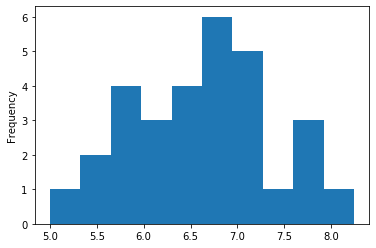

In [18]:
data_df['true_rating'].plot(kind='hist')

In [19]:
category_df = data_df.groupby(['categories']).agg({'true_rating': ['mean'], }).reset_index()


In [20]:
category_df.sort_values(by=('true_rating', 'mean'), ascending=False)

,categories,true_rating
,,mean
5,Mediterranean Restaurant,7.801695
13,Vietnamese Restaurant,7.372897
8,Performing Arts Venue,7.250538
3,Cuban Restaurant,7.241772
11,Szechuan Restaurant,7.080952
4,Indian Restaurant,7.061111
6,Music Venue,6.921569
10,Spanish Restaurant,6.865196
0,Asian Restaurant,6.628571


In [21]:
data_df.describe()

,lat,lng,distance,rating,rating_Signal,price_tier,true_rating
count,30.000000,30.000000,30.000000,30.000000,30.000000,27.000000,30.000000
mean,40.417405,-3.701487,219.233333,6.776667,44.766667,2.000000,6.634182
std,0.002875,0.002344,94.935435,0.824070,40.284063,0.392232,0.800122
min,40.412414,-3.705675,60.000000,5.000000,8.000000,1.000000,5.000000
25%,40.415090,-3.703535,141.000000,6.125000,11.250000,2.000000,6.090238
50%,40.417145,-3.701351,226.500000,6.950000,24.000000,2.000000,6.689286
75%,40.419495,-3.700110,291.000000,7.300000,68.750000,2.000000,7.075992
max,40.422675,-3.695588,385.000000,8.300000,159.000000,3.000000,8.243590


In [22]:
def rating_tier(rating):
    rating = rating[0]
    if rating < 6.07:
        return 'low'
    elif rating > 7.07:
        return 'high'
    else: 
        return 'medium'
        
category_df['rating_tier'] = category_df['true_rating'].apply(rating_tier, axis=1)
category_df

,categories,true_rating,rating_tier
,,mean,
0,Asian Restaurant,6.628571,medium
1,Chinese Restaurant,5.922672,low
2,Cocktail Bar,6.065079,low
3,Cuban Restaurant,7.241772,high
4,Indian Restaurant,7.061111,medium
5,Mediterranean Restaurant,7.801695,high
6,Music Venue,6.921569,medium
7,Paella Restaurant,5.733333,low
8,Performing Arts Venue,7.250538,high


In [23]:
def rating_tier2(rating):
    
    if rating < 6.07:
        return 'low'
    elif rating > 7.07:
        return 'high'
    else: 
        return 'medium'
        
data_df['rating_tier'] = data_df['true_rating'].apply(rating_tier2)
data_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood,rating,rating_Signal,price_tier,true_rating,rating_tier
0,Caramba. Restaurant & Bar,Restaurant,19 Calle de Alcalá,40.417741,-3.699755,288,28014,ES,Madrid,Madrid,España,"[19 Calle de Alcalá, 28014 Madrid Madrid, España]",NaN,5969465e2e26800cfee878c8,NaN,5.8,26.0,2.0,5.742857,low
1,Restaurante La Terraza de Salud,Paella Restaurant,"Calle Salud, 13",40.419170,-3.703269,60,28013,ES,Madrid,Madrid,España,"[Calle Salud, 13, 28013 Madrid Madrid, España]",NaN,4dbd614a0437955ec04a9751,NaN,5.8,22.0,3.0,5.733333,low
2,Restaurante de Sichuan,Szechuan Restaurant,NaN,40.419566,-3.701119,128,NaN,ES,NaN,NaN,España,[España],NaN,56360349498eae12045aa55d,NaN,7.3,19.0,NaN,7.080952,high
3,Restaurante Cerveceria El Jamonal,Spanish Restaurant,Mesonero Romanos,40.419543,-3.704427,162,NaN,ES,Madrid,Madrid,España,"[Mesonero Romanos, Madrid Madrid, España]",NaN,4c716caed274b60c0f67dc0d,NaN,5.7,12.0,2.0,5.600000,low
4,Restaurante Puerto Rico,Spanish Restaurant,"Chinchilla, 2",40.419336,-3.703984,121,28013,ES,Madrid,Madrid,España,"[Chinchilla, 2, 28013 Madrid Madrid, España]",NaN,4c249e59c11dc9b62dae2524,NaN,7.6,69.0,2.0,7.526761,high
5,Restaurante Casa9,Mediterranean Restaurant,"Calle REINA, 9",40.420450,-3.700359,232,28004,ES,Madrid,Madrid,España,"[Calle REINA, 9, 28004 Madrid Madrid, España]",NaN,4f0c48aac2ee59c89837b083,NaN,7.9,57.0,2.0,7.801695,high
6,Restaurante Casa Labra,Restaurant,Tetuan 12,40.416996,-3.704125,279,NaN,ES,Madrid,Madrid,España,"[Tetuan 12, Madrid Madrid, España]",NaN,55bbc016498ed18b24cfe9c5,NaN,7.3,8.0,2.0,6.840000,medium
7,restaurante variopintos,Restaurant,Carrera De San Jeronimo 5,40.416782,-3.701473,285,NaN,ES,Madrid,Madrid,España,"[Carrera De San Jeronimo 5, Madrid Madrid, Esp...",NaN,52fe887c498e07737d99bfaa,NaN,7.1,10.0,2.0,6.750000,medium
8,Restaurante Zara,Cuban Restaurant,C. Barbieri 8,40.420954,-3.700368,268,28004,ES,Madrid,Madrid,España,"[C. Barbieri 8, 28004 Madrid Madrid, España]",NaN,4b62d8a0f964a52039552ae3,NaN,7.3,77.0,2.0,7.241772,high
9,Restaurante Pozo Real,Restaurant,"calle del pozo, 6",40.416292,-3.701166,345,28012,ES,Madrid,Madrid,España,"[calle del pozo, 6 (calle cruz), 28012 Madrid ...",calle cruz,4c1e147c63750f47a427b967,NaN,6.6,13.0,2.0,6.386667,medium


In [34]:
madrid_map2 = folium.Map(location=[M_lat, M_long], zoom_start=15)
folium.Circle(
    [M_lat, M_long],
    radius= radius,
    popup='Ecco',
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.2
    ).add_to(madrid_map2)
for lat, lng, label, rating_tier in zip(data_df.lat, data_df.lng, data_df.name, data_df.rating_tier):
    if rating_tier == 'low': color = 'red'
    elif rating_tier == 'medium': color = 'yellow'
    elif rating_tier == 'high': color = 'green'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=color,
        popup=label,
        fill = True,
        fill_color=color,
        fill_opacity=1
    ).add_to(madrid_map2)
madrid_map2

In [25]:
data_df

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,neighborhood,rating,rating_Signal,price_tier,true_rating,rating_tier
0,Caramba. Restaurant & Bar,Restaurant,19 Calle de Alcalá,40.417741,-3.699755,288,28014,ES,Madrid,Madrid,España,"[19 Calle de Alcalá, 28014 Madrid Madrid, España]",NaN,5969465e2e26800cfee878c8,NaN,5.8,26.0,2.0,5.742857,low
1,Restaurante La Terraza de Salud,Paella Restaurant,"Calle Salud, 13",40.419170,-3.703269,60,28013,ES,Madrid,Madrid,España,"[Calle Salud, 13, 28013 Madrid Madrid, España]",NaN,4dbd614a0437955ec04a9751,NaN,5.8,22.0,3.0,5.733333,low
2,Restaurante de Sichuan,Szechuan Restaurant,NaN,40.419566,-3.701119,128,NaN,ES,NaN,NaN,España,[España],NaN,56360349498eae12045aa55d,NaN,7.3,19.0,NaN,7.080952,high
3,Restaurante Cerveceria El Jamonal,Spanish Restaurant,Mesonero Romanos,40.419543,-3.704427,162,NaN,ES,Madrid,Madrid,España,"[Mesonero Romanos, Madrid Madrid, España]",NaN,4c716caed274b60c0f67dc0d,NaN,5.7,12.0,2.0,5.600000,low
4,Restaurante Puerto Rico,Spanish Restaurant,"Chinchilla, 2",40.419336,-3.703984,121,28013,ES,Madrid,Madrid,España,"[Chinchilla, 2, 28013 Madrid Madrid, España]",NaN,4c249e59c11dc9b62dae2524,NaN,7.6,69.0,2.0,7.526761,high
5,Restaurante Casa9,Mediterranean Restaurant,"Calle REINA, 9",40.420450,-3.700359,232,28004,ES,Madrid,Madrid,España,"[Calle REINA, 9, 28004 Madrid Madrid, España]",NaN,4f0c48aac2ee59c89837b083,NaN,7.9,57.0,2.0,7.801695,high
6,Restaurante Casa Labra,Restaurant,Tetuan 12,40.416996,-3.704125,279,NaN,ES,Madrid,Madrid,España,"[Tetuan 12, Madrid Madrid, España]",NaN,55bbc016498ed18b24cfe9c5,NaN,7.3,8.0,2.0,6.840000,medium
7,restaurante variopintos,Restaurant,Carrera De San Jeronimo 5,40.416782,-3.701473,285,NaN,ES,Madrid,Madrid,España,"[Carrera De San Jeronimo 5, Madrid Madrid, Esp...",NaN,52fe887c498e07737d99bfaa,NaN,7.1,10.0,2.0,6.750000,medium
8,Restaurante Zara,Cuban Restaurant,C. Barbieri 8,40.420954,-3.700368,268,28004,ES,Madrid,Madrid,España,"[C. Barbieri 8, 28004 Madrid Madrid, España]",NaN,4b62d8a0f964a52039552ae3,NaN,7.3,77.0,2.0,7.241772,high
9,Restaurante Pozo Real,Restaurant,"calle del pozo, 6",40.416292,-3.701166,345,28012,ES,Madrid,Madrid,España,"[calle del pozo, 6 (calle cruz), 28012 Madrid ...",calle cruz,4c1e147c63750f47a427b967,NaN,6.6,13.0,2.0,6.386667,medium


In [26]:
red_points = data_df[data_df['rating_tier'] == 'low']
green_points = data_df[data_df['rating_tier'] == 'high']

In [27]:
for i, row in red_points.iterrows():
    center = (row.lat, row.lng)
    dist_list = []
    for lat, lng in zip(green_points.lat, green_points.lng):
        green_point = (lat, lng)
        dist_list.append(distance.distance(center, green_point).m)
    print(f'For point index {i} minimum distance to high tier rated restaurant is {min(dist_list)}')

For point index 0 minimum distance to high tier rated restaurant is 233.4246851246787
For point index 1 minimum distance to high tier rated restaurant is 63.42682654353519
For point index 3 minimum distance to high tier rated restaurant is 44.08876102511685
For point index 11 minimum distance to high tier rated restaurant is 86.94798558695737
For point index 15 minimum distance to high tier rated restaurant is 218.46271136999658
For point index 18 minimum distance to high tier rated restaurant is 54.68405320014483
For point index 21 minimum distance to high tier rated restaurant is 308.96785119696375
For point index 22 minimum distance to high tier rated restaurant is 352.41104371523556


There are 2 low rating restaurants that do not have any high rating restaurant in more than 300 meters.

In [33]:
candidate1 = data_df.iloc[21]
candidate2 = data_df.iloc[22]
folium.Circle(
    [candidate1.lat, candidate1.lng],
    radius= 309,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.2
    ).add_to(madrid_map2)
folium.Circle(
    [candidate2.lat, candidate2.lng],
    radius= 352,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.2
    ).add_to(madrid_map2)
madrid_map2

Candidate 1 seems really promissing, it seems that there is a business oportunity for a higher rated restaurant in the west side of the center of madrid